# Data Augmentation For Object Detection

This notebook serves as general manual to using this codebase. We cover all the major augmentations, as well as ways to combine them. 

In [2]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

## Storage Format 

First things first, we define how the storage formats required for images to work. 
1. **The Image**: A OpenCV numpy array, of shape *(H x W x C)*. 
2. **Annotations**: A numpy array of shape *N x 5* where *N* is the number of objects, one represented by each row. 5 columns represent the top-left x-coordinate, top-left y-coordinate, bottom-right x-coordinate, bottom-right y-coordinate, and the class of the object. 

Here is an image to aid your imagination. 

![Annotation Format](ann_form.jpg)

Whatever format your annotations are present in make sure, you convert them to this format.

For demonstration purposes, we will be using the image above to show the transformations. The image as well as it's annotation has been provided. The annotation is a numpy array in a pickled format. 

### 이미지와 yolo label을 읽어온다.

In [5]:
import os
fileName = os.path.join("C:/Users/BIT-R42/opencvEx/labelImg/data", "messi.jpg")
# fileName = os.path.join("C:/Users/Administrator/PycharmProjects/opencvEx_python/labelImg\data", "messi.jpg")

In [8]:
inner = []

img = cv2.imread(fileName)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_width = img.shape[1]
img_height = img.shape[0]

white_color = (255, 255, 255)

# jpg 확장자만 분리하여 txt파일 열기
name, ext = os.path.splitext(fileName)

# yolo v4포맷 파일 열기
try:
    f = open(name+".txt", 'r')
except OSError:
    print('cannot open ' + name + '.txt')

while True:
    # 문자열 한줄을 읽어와서
    line = f.readline()
    
    # 문자열이 비어있다면 종료
    if not line: 
        break

    # 문자열이 비어있지 않으면 문자열 나눠서 디코딩
    classNum, x, y, width_ratio, height_ratio = line.split(' ')
    # 박스의 센터 좌표값
    x_pos = round(img_width * float(x))
    y_pos = round(img_height * float(y))
    width_pixel = round(img_width * float(width_ratio))
    height_pixel = round(img_height *float(height_ratio))
    x1 = round(x_pos - width_pixel/2)
    y1 = round(y_pos - height_pixel/2)
    x2 = round(x_pos + width_pixel/2)
    y2 = round(y_pos + height_pixel/2)

    #img = cv2.rectangle(img, (x1,y1), (x2,y2), white_color, 3)
    print(x1, y1, x2, y2)
    
    inner.append([float(x1), float(y1), float(x2), float(y2), int(classNum)])
    
f.close()
bboxes = np.array(inner)

247 100 301 160
348 117 404 165
208 50 244 80
673 88 703 112
726 330 794 394


In [9]:
print(bboxes)

[[247. 100. 301. 160.   1.]
 [348. 117. 404. 165.   1.]
 [208.  50. 244.  80.   1.]
 [673.  88. 703. 112.   1.]
 [726. 330. 794. 394.   2.]]


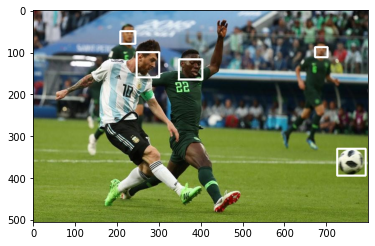

In [10]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

In [53]:
def label2Yolo(bboxes, image_size, name):
    f = open(name+'_HFlip.txt', 'w')
    
    for value in bboxes: 
        x1,y1,x2,y2,classNum = value
        img_width    = x2 - x1
        img_height   = y2 - y1
        width_ratio  = img_width / image_size[0]
        height_ratio = img_height / image_size[1]
        yolo_x1      = (x1 + img_width/2) / image_size[0]
        yolo_y1      = (y1 + img_height/2) / image_size[1]
        f.write(str(int(classNum)) + ' ' +str(round(yolo_x1,4)) + ' '+str(round(yolo_y1,4))+' '+str(round(width_ratio,4))+' '+str(round(height_ratio,4))+'\n')
    
    f.close()
    #return bboxes_

### yolo label을 픽셀 좌표로 변경

In [40]:
# img = cv2.imread("messi.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
# bboxes = pkl.load(open("messi_ann.pkl", "rb"))

# #inspect the bounding boxes
# print(bboxes)

You can use the function `draw_rect` to plot the bounding boxes on an image. 

In [39]:
# result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(12,12))
# plt.imshow(result)
# plt.show()


Now, we can get started with our image augmentations. The first one is **Horizontal Flipping**. The function takes one arguement, *p* which is the probability that the image will be flipped. 

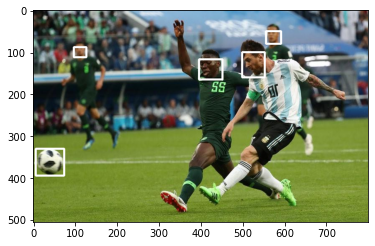

In [54]:
# 이미지 좌우 대칭을 실행
# 함수의 결과는 좌우 대칭된 이미지와 박스 좌표값을 리턴한다.
img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
HFlipImage = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)

# 좌우 대칭 이미지 저장
cv2.imwrite(name+'_HFlip.jpg', HFlipImage)

img_size = (img_.shape[1], img_.shape[0])
# 좌우 대칭 레이블 텍스트로 저장
label2Yolo(bboxes_, img_size, name)

plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Scaling**. Scales the image. If the argument *diff* is True, then the image is scaled with different values in the vertical and the horizontal directions, i.e. aspect ratio is not maintained. 

If the first argument is a float, then the scaling factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

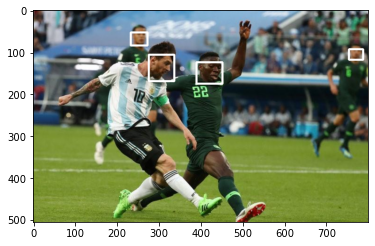

In [55]:
img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Translation**. Translates the image. If the argument *diff* is True, then the image is translated with different values in the vertical and the horizontal directions.

If the first argument is a float, then the translating factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

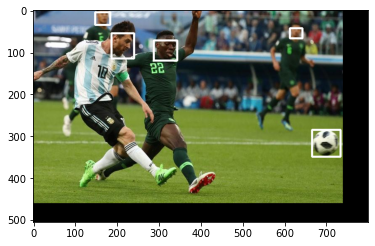

In [56]:
img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Rotation**. Rotates the image. 

If the first argument is a int, then the rotating angle, in degrees, is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

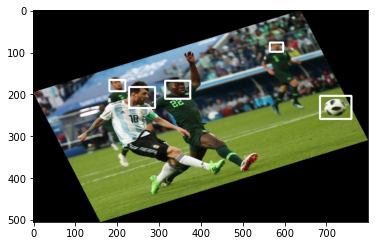

In [83]:
# 인수 = 세타값(이동 각도)만큼 랜덤 이동
img_, bboxes_ = RandomRotate(45)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Shearing**. Sheares the image horizontally

If the first argument is a float, then the shearing factor is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

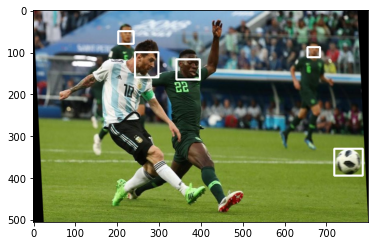

In [58]:
img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Resizing**.  Resizes the image to square dimensions while keeping the aspect ratio constant.

The argument to this augmentation is the side of the square.

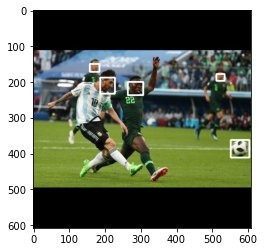

In [59]:
img_, bboxes_ = Resize(608)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

HSV transforms are supported as well. 

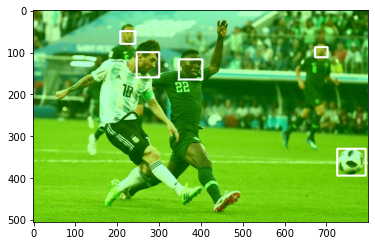

In [60]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

You can combine multiple transforms together by using the Sequence class as follows. 

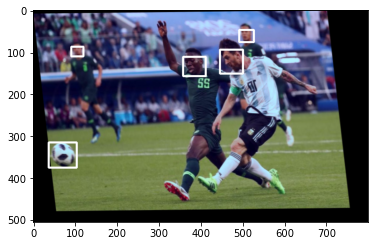

In [61]:
seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())

plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

A list of all possible transforms can be found in the `docs` folder.






폴더에서 이미지 리스트를 불러오고
[Horizontal Flipping] 그 이미지들을 한꺼번에 , 원본파일명_Hflip.jpg, 원본파일명_Hflip.txt
[Scaling] 원본파일명_scal.jpg, 원본파일명_scal.txt
[Translation] 원본파일명_trans.jpg, 원본파일명_trans.txt
[Rotation] 원본파일명_rotate.jpg, 원본파일명_rotate.txt (각도)